# Calculating Queue per Link (src,dst,act)
* import libraries
* create the RSE to site mapping
* get the data +/- 5 days
* calculate the queues per link
* plot plot plot

In [1]:
%matplotlib inline
import matplotlib
matplotlib.rc('font', **{'size': 12})

import pickle
import re
import datetime
from elasticsearch import Elasticsearch, helpers
from elasticsearch.helpers import scan
import datetime as dt

import numpy as np
import pandas as pd

import requests
import json

import time

In [2]:
# Get AGIS endpoints (RSEs) and site names
r = requests.get('http://atlas-agis-api.cern.ch/request/site/query/list/ddmendpoints?json')
j = r.json()
#Create RSE to site name dictionary
rse2site = {}
for i in j:
    for ep in i['ddmendpoints']:
        rse2site[ep]=i['name']

#### Geting data from ElasticSearch

In [3]:
es = Elasticsearch([{'host':'atlas-kibana.mwt2.org', 'port':9200}],timeout=60)
DATE = '2017-02-01'  # yyyy-mm-dd
DELTA = 5
# Generate the indexes to scan
dt.datetime.strptime(DATE,'%Y-%m-%d')
index_list = []
for i in range(-DELTA, DELTA+1):
    index_list.append('fts_'+(dt.datetime.strptime(DATE,'%Y-%m-%d')
                      + dt.timedelta(days=i)).strftime('%Y-%m-%d'))
indexes = ','.join(index_list)

In [4]:
period_start = dt.datetime.strptime(DATE,'%Y-%m-%d')
period_end = dt.datetime.strptime(DATE,'%Y-%m-%d') + dt.timedelta(days=1)
transfer_query = {
    "size": 0,
    "_source": ["src_rse", "dst_rse", "activity","bytes","submitted_at","started_at","transferred_at"],
    'query':{
        "bool" : {
            "must" : [
                {"range" : {"transferred_at" : {  "gte": period_start } }},
                {"range" : {"submitted_at" :   {  "lt" : period_end } }}
                ]
        }
    }
                
}
data=[]
scroll = scan(client=es, index=indexes, query=transfer_query, scroll='5m', timeout="5m", size=10000)
epoch = dt.datetime(1970,1,1)
st = time.time()
count = 0
for res in scroll:
    r = res['_source']
    # filter only the transfers between DATE and DATE+1day
    #if (dt.datetime.strptime(r['submitted_at'].strip('Z').split('.')[0], '%Y-%m-%dT%H:%M:%S') < dt.datetime.strptime(DATE,'%Y-%m-%d'))or(dt.datetime.strptime(r['transferred_at'].strip('Z').split('.')[0], '%Y-%m-%dT%H:%M:%S') > (dt.datetime.strptime(DATE,'%Y-%m-%d')+dt.timedelta(days=1))):
    #    continue
    r['submitted_at'] = (dt.datetime.strptime(r['submitted_at'].strip('Z').split('.')[0], '%Y-%m-%dT%H:%M:%S') - epoch).total_seconds()
    r['started_at'] = (dt.datetime.strptime(r['started_at'].strip('Z').split('.')[0], '%Y-%m-%dT%H:%M:%S') - epoch).total_seconds()
    r['transferred_at'] = (dt.datetime.strptime(r['transferred_at'].strip('Z').split('.')[0], '%Y-%m-%dT%H:%M:%S') - epoch).total_seconds()
    data.append([r['src_rse'],r['dst_rse'],r['activity'],r['bytes'],r['submitted_at'],r['started_at'],r['transferred_at']])
    count += 1
    if not count%100000 : print (count)
print('Reading took',time.time() - st,'seconds.')
data = pd.DataFrame(data, columns=['SRC', 'DST', 'ACT', 'SIZE', 'SUBMITTED', 'STARTED', 'ENDED'])
#data['QUEUE_T'] = data.STARTED - data.SUBMITTED
#data['NET_T'] = data.ENDED - data.STARTED
data['RATE'] = data.SIZE / (data.ENDED - data.STARTED)
src_sites = [rse2site[rse] for rse in data.SRC.values]
dst_sites = [rse2site[rse] for rse in data.DST.values]
data['SRC_SITE'] = src_sites
data['DST_SITE'] = dst_sites
print('Documents:', len(data))

100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
1200000
1300000
1400000
1500000
1600000
1700000
1800000
1900000
Reading took 223.92373132705688 seconds.
Documents: 1961719


Index(['SRC', 'DST', 'ACT', 'SIZE', 'SUBMITTED', 'STARTED', 'ENDED', 'QUEUE_T',
       'NET_T', 'RATE'],
      dtype='object')

In [13]:
delta = (dt.datetime.strptime(DATE, '%Y-%m-%d') - epoch).total_seconds()
link_queue = {}

st = time.time()
for row in data.itertuples():
    link = rse2site[row.SRC]+'__'+rse2site[row.DST]+'__'+row.ACT
    start = int((row.SUBMITTED - delta)/60)
    end = int((row.STARTED - delta)/60)
    if start > end:
        end = start
    if link not in link_queue.keys():
        link_queue[link] = [0]*1440
    for i in range(start, end+1):
        if i < 0 or i >= 1440:
            continue
        link_queue[link][i] += 1
print(time.time() - st)

88.37128710746765


In [14]:
len(link_queue.keys())

9927

### Plots for CERN / BNL link

In [15]:
# the date index is from delta to delta+1 day in seconds.
date_index = range(int(delta), int(delta)+24*60*60, 60)
date_index = list(map(dt.datetime.utcfromtimestamp,date_index))

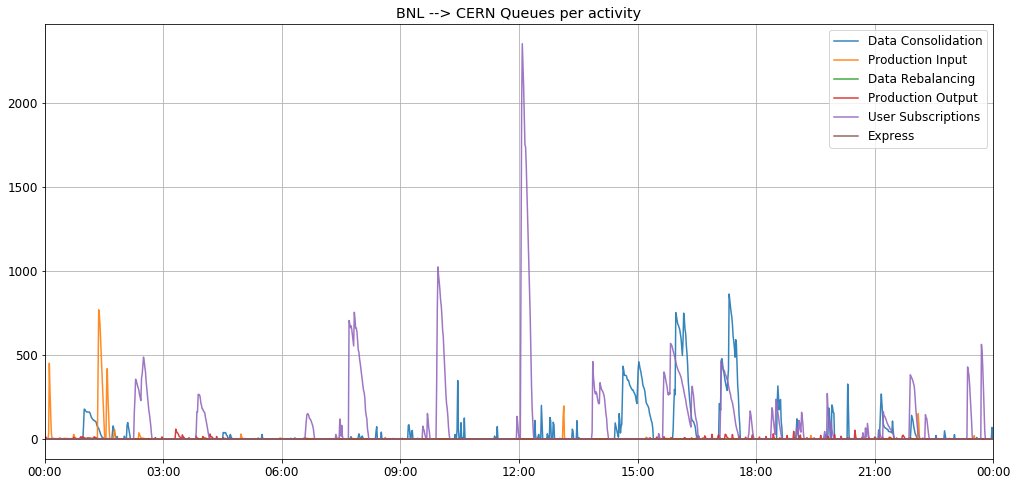

In [27]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
plt.title('BNL --> CERN Queues per activity')
for act in ['Data Consolidation', 'Production Input', 'Data Rebalancing', 'Production Output', 'User Subscriptions', 'Express']:
    link = 'BNL-ATLAS__CERN-PROD__'+act
    plt.plot(date_index, np.array(link_queue[link]),'-', alpha=0.9, label=act)
#plt.plot(range(14000), np.array(link_files['CERN-PROD__BNL-ATLAS']),'.', alpha=0.5, label='source rate')
#plt.yscale('log')
plt.xlim(dt.datetime.utcfromtimestamp(delta),dt.datetime.utcfromtimestamp(delta+24*60*60))
ax=plt.gca()
xfmt = mdates.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(xfmt)
fig = plt.gcf()
fig.set_size_inches(17, 8)
plt.legend()
plt.grid()
plt.show()

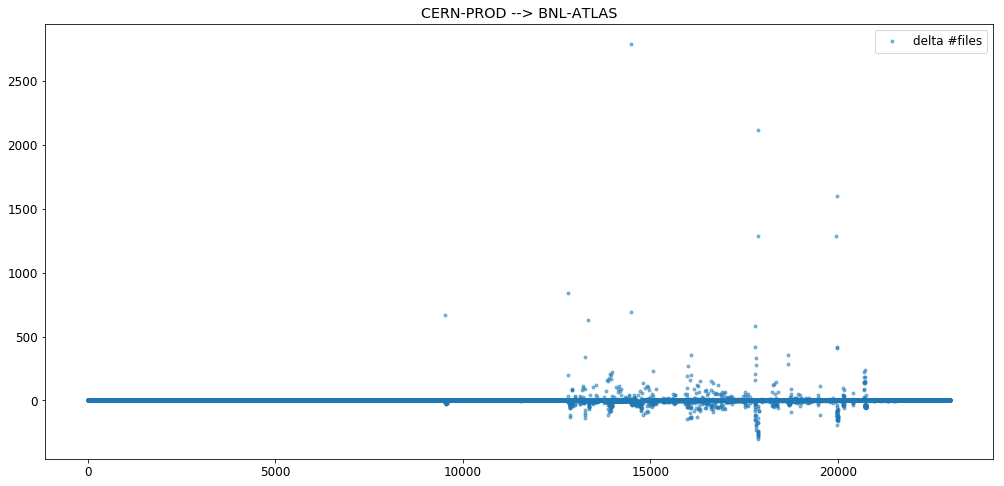

In [44]:
import matplotlib.pyplot as plt
plt.title('CERN-PROD --> BNL-ATLAS')
#plt.plot(range(23000), np.array(link_queue['CERN-PROD__BNL-ATLAS__Data Rebalancing']),'.', alpha=0.5, label='#files in FTS QUEUE')
plt.plot(range(23000), deltas,'.', alpha=0.5, label='delta #files')
#plt.yscale('log')
fig = plt.gcf()
fig.set_size_inches(17, 8)
plt.legend()
plt.show()

In [43]:
deltas = [0]
for x0,x1 in zip(link_queue['CERN-PROD__BNL-ATLAS__User Subscriptions'],
                 link_queue['CERN-PROD__BNL-ATLAS__User Subscriptions'][1:]):
    deltas.append(x1-x0)
len(deltas)

23000

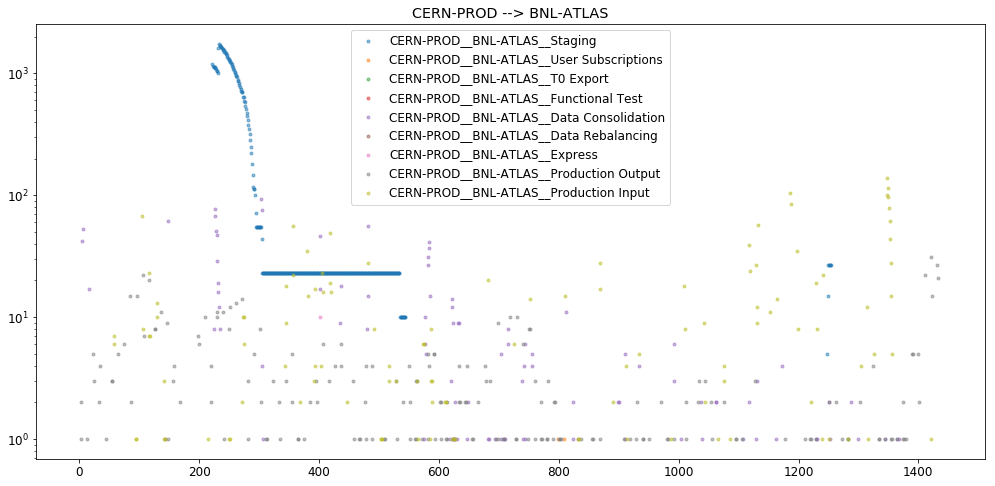

In [65]:
import matplotlib.pyplot as plt
plt.title('CERN-PROD --> BNL-ATLAS')
#plt.plot(range(14000), dst_rate['CERN-PROD'], '-k', alpha=0.5, label='cern rate')
#plt.plot(range(14000), src_rate['CERN-PROD'], '-k', alpha=0.5, label='cern rate')
for l in link_queue:
    if l.startswith('CERN-PROD__BNL'):
        plt.plot(range(1440), link_queue[l][10751:12191], '.', alpha=0.5, label=l)
#plt.plot(range(14000), src_rate['CERN-PROD'], '-', alpha=0.5, label='cern rate')
#plt.plot(range(14000), dst_rate['BNL-ATLAS'], '-', alpha=0.5, label='bnl rate')
#plt.plot(range(14000), link_rate['CERN-PROD__BNL-ATLAS'], '-', alpha=0.5, label='cern->bnl rate')
plt.yscale('log')
fig = plt.gcf()
fig.set_size_inches(17, 8)
plt.legend()
plt.show()

In [30]:
deltas = [0]
for x0,x1 in zip(link_queue['CERN-PROD__BNL-ATLAS__Data Rebalancing'],
                 link_queue['CERN-PROD__BNL-ATLAS__Data Rebalancing'][1:]):
    deltas.append(x1-x0)
len(deltas)

23000

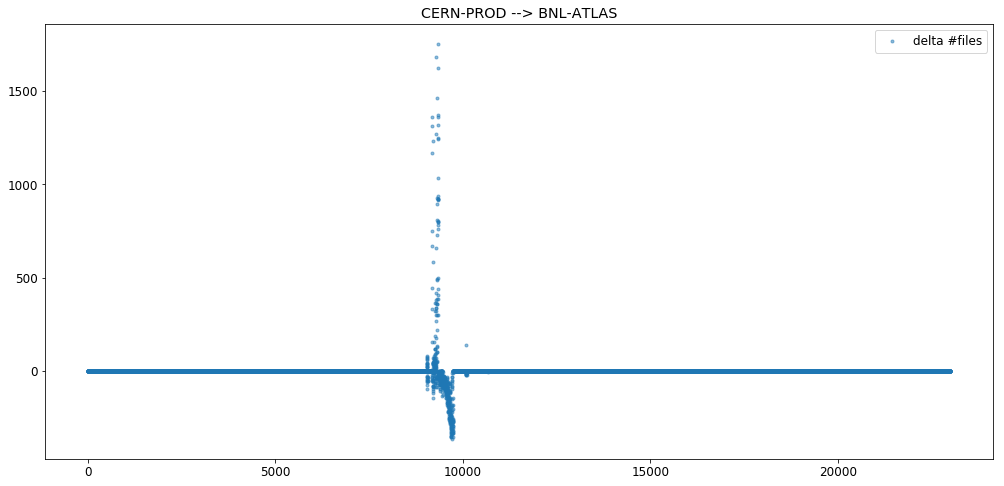

In [42]:
import matplotlib.pyplot as plt
plt.title('CERN-PROD --> BNL-ATLAS')
#plt.plot(range(23000), np.array(link_queue['CERN-PROD__BNL-ATLAS__Data Rebalancing']),'.', alpha=0.5, label='#files in FTS QUEUE')
plt.plot(range(23000), deltas,'.', alpha=0.5, label='delta #files')
#plt.yscale('log')
fig = plt.gcf()
fig.set_size_inches(17, 8)
plt.legend()
plt.show()

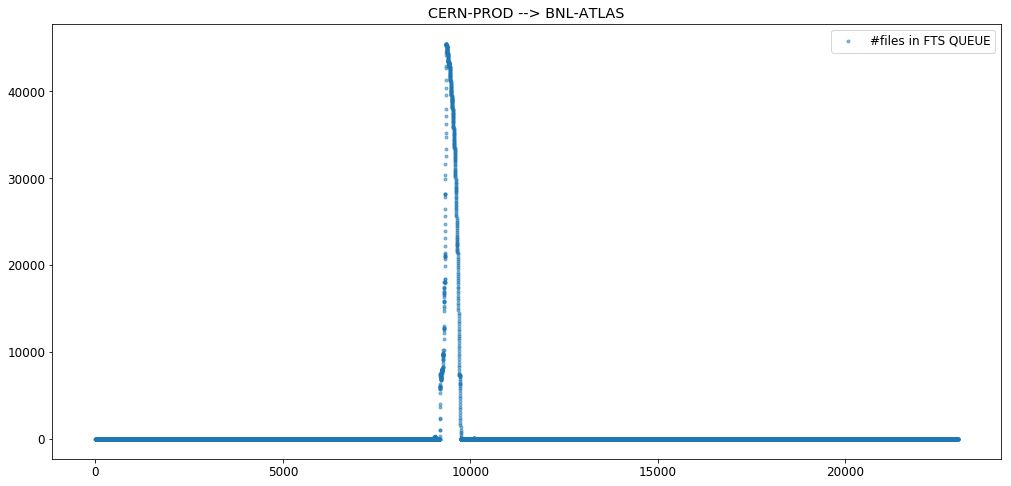

In [41]:
import matplotlib.pyplot as plt
plt.title('CERN-PROD --> BNL-ATLAS')
plt.plot(range(23000), np.array(link_queue['CERN-PROD__BNL-ATLAS__Data Rebalancing']),'.', alpha=0.5, label='#files in FTS QUEUE')
#plt.plot(range(23000), deltas,',', alpha=0.5, label='delta #files')
#plt.yscale('log')
fig = plt.gcf()
fig.set_size_inches(17, 8)
plt.legend()
plt.show()

In [45]:
deltas = [0]
for x0,x1 in zip(link_queue['CERN-PROD__BNL-ATLAS__Production Input'],
                 link_queue['CERN-PROD__BNL-ATLAS__Production Input'][1:]):
    deltas.append(x1-x0)
len(deltas)

23000

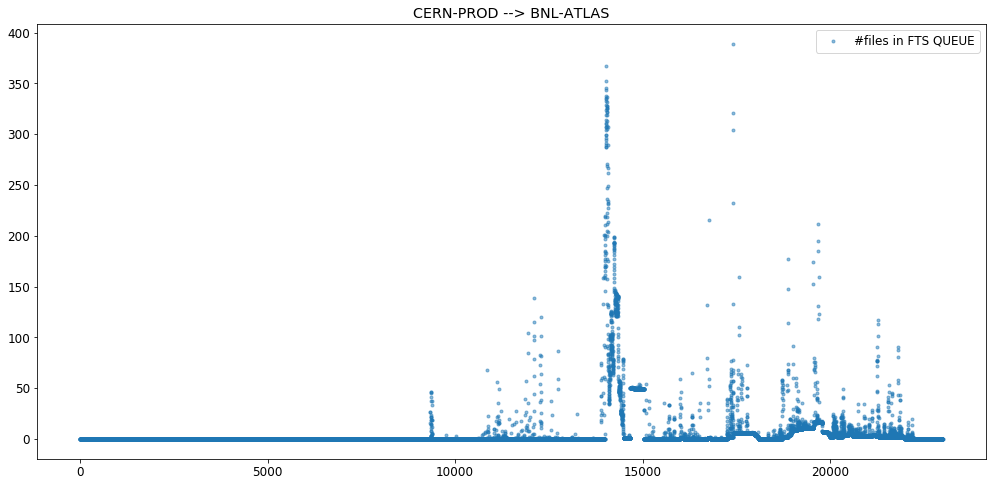

In [47]:
import matplotlib.pyplot as plt
plt.title('CERN-PROD --> BNL-ATLAS')
plt.plot(range(23000), np.array(link_queue['CERN-PROD__BNL-ATLAS__Production Input']),'.', alpha=0.5, label='#files in FTS QUEUE')
#plt.plot(range(23000), deltas,',', alpha=0.5, label='delta #files')
#plt.yscale('log')
fig = plt.gcf()
fig.set_size_inches(17, 8)
plt.legend()
plt.show()

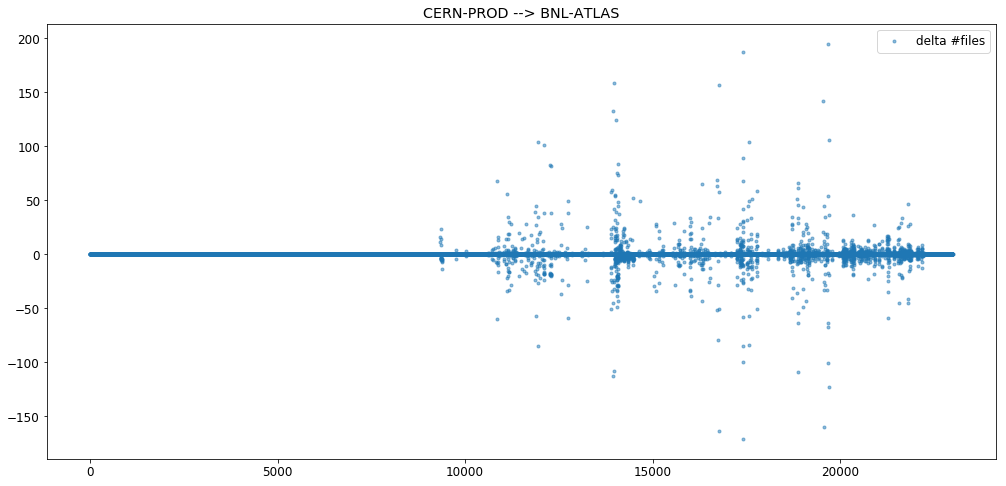

In [48]:
import matplotlib.pyplot as plt
plt.title('CERN-PROD --> BNL-ATLAS')
#plt.plot(range(23000), np.array(link_queue['CERN-PROD__BNL-ATLAS__Data Rebalancing']),'.', alpha=0.5, label='#files in FTS QUEUE')
plt.plot(range(23000), deltas,'.', alpha=0.5, label='delta #files')
#plt.yscale('log')
fig = plt.gcf()
fig.set_size_inches(17, 8)
plt.legend()
plt.show()

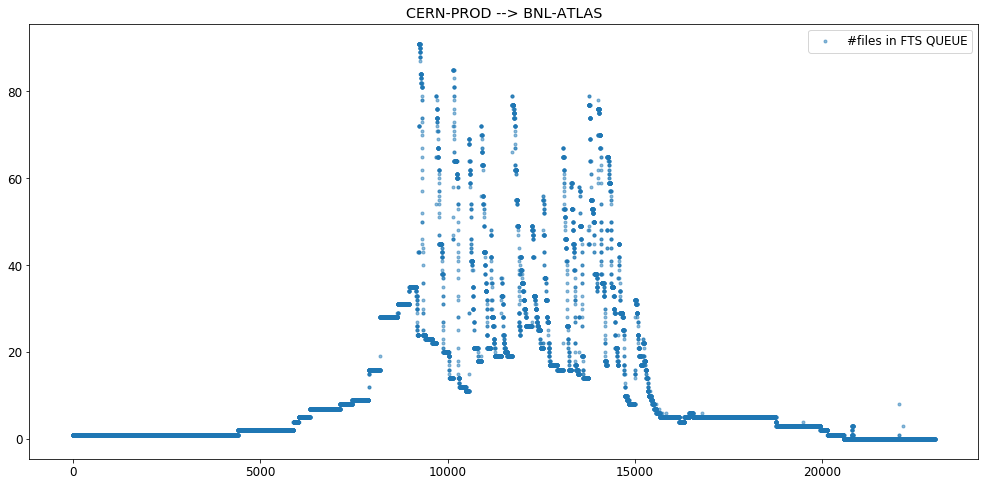

In [51]:
import matplotlib.pyplot as plt
plt.title('BNL-ATLAS --> FMPhI-UNIBA')
plt.plot(range(23000), np.array(link_queue['BNL-ATLAS__FMPhI-UNIBA__Data Consolidation']),'.', alpha=0.5, label='#files in FTS QUEUE')
#plt.plot(range(23000), deltas,',', alpha=0.5, label='delta #files')
#plt.yscale('log')
fig = plt.gcf()
fig.set_size_inches(17, 8)
plt.legend()
plt.show()